In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa # for processing audios
import librosa.display
import numpy as np
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import fnmatch

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import tensorflow as tf 
print('tensorflow version: ', tf.__version__)
import keras
print('keras version: ',keras.__version__)

tensorflow version:  2.5.0
keras version:  2.5.0


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
INPUT_DIR="drive/MyDrive/heartbeat_sound"

set_b=pd.read_csv(INPUT_DIR+"/set_b.csv")
set_b.head()

dataset  ... sublabel
0       b  ...      NaN
1       b  ...      NaN
2       b  ...      NaN
3       b  ...      NaN
4       b  ...      NaN

[5 rows x 4 columns]

In [ ]:
#get all unique labels
nb_classes=set_b.label.unique()

print("Number of training examples=", set_b.shape[0], "  Number of classes=", len(set_b.label.unique()))
print (nb_classes)

Number of training examples= 461   Number of classes= 3
['extrastole' 'murmur' 'normal']


In [ ]:
# simple encoding of categories, limited to 3 types

# Map label text to integer
CLASSES = ['normal', 'murmur', 'extrasystole']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)

# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'normal': 0, 'murmur': 1, 'extrasystole': 2}
 
{0: 'normal', 1: 'murmur', 2: 'extrasystole'}


# Load and Preprocess Dataset

In [ ]:
from scipy import signal
from scipy.signal import butter, lfilter

# A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(data, cutoff_low, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff_low/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    y = lfilter(b, a, data)

    return y

In [ ]:
fs = 16000
cutoff_low = 195
order = 3

# get audio data with a fix padding may also chop off some file
def load_file_data(folder, file_names, total_sample=192000, sr=16000):
  data = []
  for file_name in file_names:
      try:
          # load audio
          sound_file=folder+file_name
          print ("load file ", sound_file)
          X, sr = librosa.load(sound_file, sr=sr, res_type='kaiser_fast')
          
          # to fix each audio length to fixed frames
          while X.size < total_sample:
              print ("fixing audio length :", file_name)
              X = np.concatenate((X, X))
          if X.size > total_sample:
              X = X[:total_sample]
          
          filtered = butter_lowpass(X, cutoff_low, fs, order)

          fig, ax = plt.subplots(1, 2, figsize=(20, 5))
          ax[0].plot(X)
          ax[1].plot(filtered)
                
          mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40, n_fft=2048, hop_length=512).T, axis=0)
          
      except Exception as e:
          print("Error encountered while parsing file: ", sound_file)  
      feature = np.array(mfccs).reshape([-1,1])
      data.append(feature)
  return data


In [ ]:
setb_folder=INPUT_DIR+'/set_b/'

normal_files = fnmatch.filter(os.listdir(setb_folder), 'normal*.wav') 
normal_sounds = load_file_data(folder=setb_folder, file_names=normal_files)
normal_labels = [0 for items in normal_sounds]

murmur_files = fnmatch.filter(os.listdir(setb_folder), 'murmur*.wav')
murmur_sounds = load_file_data(folder=setb_folder, file_names=murmur_files)
murmur_labels = [1 for items in murmur_files]

extrasystole_files = fnmatch.filter(os.listdir(setb_folder), 'extrastole*.wav')
extrasystole_sounds = load_file_data(folder=setb_folder, file_names=extrasystole_files)
extrasystole_labels = [2 for items in extrasystole_files]

load file  drive/MyDrive/heartbeat_sound/set_b/normal__174_1307987737137_B1.wav
fixing audio length : normal__174_1307987737137_B1.wav
fixing audio length : normal__174_1307987737137_B1.wav
fixing audio length : normal__174_1307987737137_B1.wav
Error encountered while parsing file:  drive/MyDrive/heartbeat_sound/set_b/normal__174_1307987737137_B1.wav
load file  drive/MyDrive/heartbeat_sound/set_b/normal__214_1308245489717_A.wav
fixing audio length : normal__214_1308245489717_A.wav
fixing audio length : normal__214_1308245489717_A.wav
fixing audio length : normal__214_1308245489717_A.wav
Error encountered while parsing file:  drive/MyDrive/heartbeat_sound/set_b/normal__214_1308245489717_A.wav
load file  drive/MyDrive/heartbeat_sound/set_b/normal__210_1308162935880_B1.wav
fixing audio length : normal__210_1308162935880_B1.wav
fixing audio length : normal__210_1308162935880_B1.wav
fixing audio length : normal__210_1308162935880_B1.wav
fixing audio length : normal__210_1308162935880_B1.wav

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


fixing audio length : normal__194_1308139824187_A.wav
Error encountered while parsing file:  drive/MyDrive/heartbeat_sound/set_b/normal__194_1308139824187_A.wav
load file  drive/MyDrive/heartbeat_sound/set_b/normal__133_1306759619127_D.wav
fixing audio length : normal__133_1306759619127_D.wav
fixing audio length : normal__133_1306759619127_D.wav
fixing audio length : normal__133_1306759619127_D.wav
fixing audio length : normal__133_1306759619127_D.wav
Error encountered while parsing file:  drive/MyDrive/heartbeat_sound/set_b/normal__133_1306759619127_D.wav
load file  drive/MyDrive/heartbeat_sound/set_b/normal__191_1308077299430_B.wav
fixing audio length : normal__191_1308077299430_B.wav
Error encountered while parsing file:  drive/MyDrive/heartbeat_sound/set_b/normal__191_1308077299430_B.wav
load file  drive/MyDrive/heartbeat_sound/set_b/normal__134_1306428161797_D.wav
fixing audio length : normal__134_1306428161797_D.wav
fixing audio length : normal__134_1306428161797_D.wav
fixing aud

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#combine data
x_data = np.concatenate((normal_sounds, murmur_sounds, extrasystole_sounds))
y_data = np.concatenate((normal_labels, murmur_labels, extrasystole_labels))

print ("combined training data record (X): ", len(x_data))
print ("combined training data record (Y): ", len(y_data))

combined training data record (X):  461
combined training data record (Y):  461


# Before and After Band Pass Filter

load file  drive/MyDrive/heartbeat_sound/set_b/normal_noisynormal_105_1305033453095_C.wav
fixing audio length : normal_noisynormal_105_1305033453095_C.wav


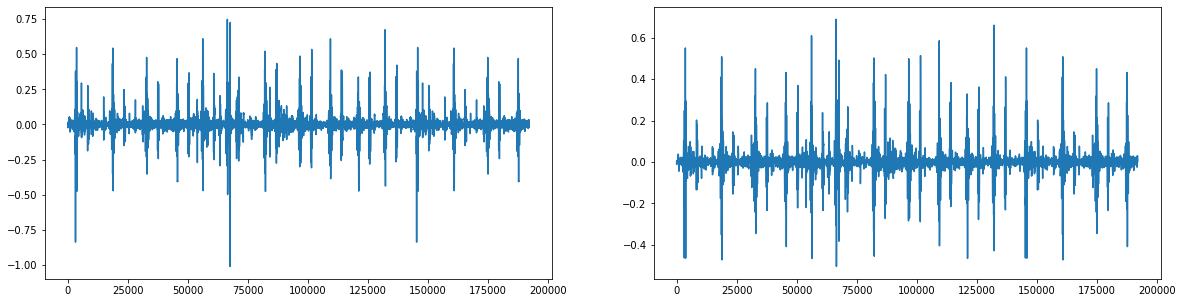

In [ ]:
setb_folder=INPUT_DIR+'/set_b/'

normal_files = fnmatch.filter(os.listdir(setb_folder), 'normal_noisynormal_105_1305033453095_C.wav') 
normal_sounds = load_file_data(folder=setb_folder, file_names=normal_files)

load file  drive/MyDrive/heartbeat_sound/set_b/normal__174_1307987737137_B1.wav
fixing audio length : normal__174_1307987737137_B1.wav
fixing audio length : normal__174_1307987737137_B1.wav
fixing audio length : normal__174_1307987737137_B1.wav


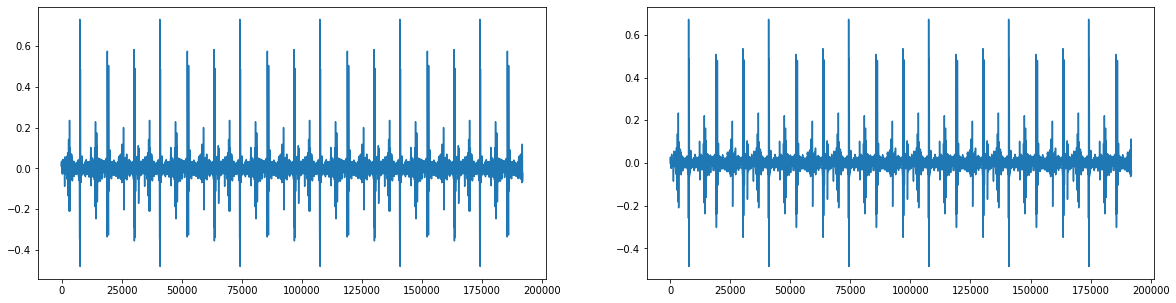

In [ ]:
setb_folder=INPUT_DIR+'/set_b/'

normal_files = fnmatch.filter(os.listdir(setb_folder), 'normal__174_1307987737137_B1.wav') 
normal_sounds = load_file_data(folder=setb_folder, file_names=normal_files)

#Model Training

In [ ]:
from sklearn.model_selection import train_test_split

seed = 100
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.np_utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.np_utils.to_categorical(y_test, len(CLASSES)))
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(414, 40, 1)
(414, 3)
(47, 40, 1)
(47, 3)


In [ ]:
%%time
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=128)

# K-fold Cross Validation model evaluation
fold_no = 1

for train, test in kfold.split(X_train, y_train):

  model = Sequential()
  model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.2, return_sequences=True, input_shape=(40, 1)))
  model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.2))
  model.add(Dense(len(CLASSES), activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adamax(learning_rate=0.01), metrics=['acc', keras.metrics.AUC()])
  model.summary()

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(
      X_train[train], y_train[train],
                      batch_size=32,
                      epochs=100,
                      verbose=1
                      )

  # Generate generalization metrics
  scores = model.evaluate(X_train[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
11/11 [==============================] - 12s 389ms/step - loss: 0.5745 - acc: 0.6581 - auc: 0.7728

Epoch 00001: loss improved from inf to 0.53139, saving model to drive/MyDrive/best_heartsound_model.hdf5
Epoch 2/100
11/11 [==============================] - 4s 386ms/step -

In [ ]:
print(acc_per_fold)
print(loss_per_fold)

[69.87951993942261, 73.49397540092468, 72.28915691375732, 68.67470145225525, 67.07317233085632]
[0.4668377935886383, 0.4664950966835022, 0.47314348816871643, 0.4643780291080475, 0.5647685527801514]


In [ ]:
from keras.models import load_model

# Keras reported accuracy:
score = model.evaluate(X_test, y_test, verbose=1) 
print ("model train data score       : ", score[1])

2/2 [==============================] - 0s 38ms/step - loss: 0.4252 - acc: 0.7872 - auc_4: 0.8654
model train data score       :  0.7872340679168701


In [ ]:
model.save('drive/MyDrive/heart_sound78.7%.hdf5')